## CIS 519 Group Project - Vision Transformer (ViT) Implementation

### Library Imports

In [3]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

In [2]:
!pip install --upgrade torch torchvision
!pip install einops
!pip install nvidia-ml-py
!pip -q install vit_pytorch linformer

  Using cached torch-1.10.2-cp36-cp36m-manylinux1_x86_64.whl (881.9 MB)


In [3]:
from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline
import torch.optim as optim 
from linformer import Linformer
from torch import nn
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

### Helper Functions

In [4]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)
            
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("On which device we are on:{}".format(device))

On which device we are on:cuda


In [6]:
import zipfile
with zipfile.ZipFile("datasetml.zip","r") as zip_ref:
    zip_ref.extractall("dataset") 

In [8]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [6]:
def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
    epochs = len(train_loss)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
    ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Epoch vs Loss')
    ax1.legend()

    ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
    ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Epoch vs Accuracy')
    ax2.legend()
    fig.set_size_inches(15.5, 5.5)
    plt.show()

In [7]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

### Parameter Initiliazation 

In [36]:
class config_params:
    batch_size = 16                        # Batch Size for Dataset
    img_size = 224                         # Resize all the images to be 224 by 224  
    epochs = 5
    lr = 0.001                             # Resize all the images to be 224 by 224   
    in_channels = 3
    num_classes = 6

### Data Loading

In [4]:
data_dir = './dataset'
classes = os.listdir(data_dir)

In [5]:
classes

['AbdomenCT', 'CXR', 'BreastMRI', 'ChestCT', 'HeadCT', 'Hand']

In [10]:
train_transform = transforms.Compose([
                             
                             transforms.Resize(size=(config_params.img_size,config_params.img_size)), # Resizing the image to be 224 by 224
                             transforms.RandomRotation(degrees=(-20,+20)), #Randomly Rotate Images by +/- 20 degrees, Image argumentation for each epoch
                             transforms.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

validate_transform = transforms.Compose([
                             
                             transforms.Resize(size=(config_params.img_size,config_params.img_size)), # Resizing the image to be 224 by 224
                             transforms.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

test_transform = transforms.Compose([
                             
                             transforms.Resize(size=(config_params.img_size,config_params.img_size)), # Resizing the image to be 224 by 224
                             transforms.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

In [11]:
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of the dataset :', len(dataset))

Size of the dataset : 58954


In [12]:
img, label = dataset[100]
print(img.shape)

torch.Size([3, 224, 224])


In [13]:
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  BreastMRI (1)


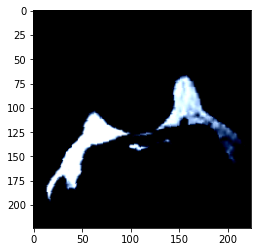

In [14]:
show_image(*dataset[10001])

In [15]:
torch.manual_seed(20)
val_size = int(round(len(dataset) * 0.2, 0))
test_size = int(round(len(dataset) * 0.1, 0))
train_size = len(dataset) - val_size -test_size

In [16]:
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds),len(test_ds)  

(41268, 11791, 5895)

In [17]:
batch_size = config_params.batch_size
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4)
test_loader = DataLoader(test_ds, batch_size*2, num_workers=4)

### Model Definition

In [19]:
class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, transformer, pool = 'cls', channels = 3):
        super().__init__()
        image_size_h, image_size_w = pair(image_size)
        assert image_size_h % patch_size == 0 and image_size_w % patch_size == 0, 'image dimensions must be divisible by the patch size'
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'
        num_patches = (image_size_h // patch_size) * (image_size_w // patch_size)
        patch_dim = channels * patch_size ** 2

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.transformer = transformer

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.Linear(in_features= dim, out_features=128), 
            nn.ReLU(), 
            nn.Dropout(p=0.3),
            nn.Linear(in_features=128, out_features= config_params.num_classes), 
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [20]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

In [21]:
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=6,
    transformer=efficient_transformer,
    channels=3,
).to(device)

### Training and Testing

In [23]:
from sklearn.metrics import confusion_matrix
    
class Trainer():
    
    def __init__(self, criterion = None,optimizer = None,schedular = None):
        
        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular
    
    def train_batch_loop(self,model,train_loader):
        
        train_loss = 0.0
        train_acc = 0.0
        
        for images,labels in tqdm(train_loader): 
            
            # move the data to CPU
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = self.criterion(outputs,labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            train_acc += accuracy(outputs,labels)
            
        return train_loss / len(train_loader), train_acc / len(train_loader) 

    
    def valid_batch_loop(self,model,val_loader):
        
        valid_loss = 0.0
        valid_acc = 0.0
        for images,labels in tqdm(val_loader):
            
            # move the data to CPU
            images = images.to(device) 
            labels = labels.to(device)
            
            outputs = model(images)
            loss = self.criterion(outputs,labels)
             
            valid_loss += loss.item()
            valid_acc += accuracy(outputs,labels)
            

        return valid_loss / len(val_loader), valid_acc / len(val_loader)
    
    def test_batch_loop(self,model,test_loader):
        y_pred = []
        y_true = []
        test_loss = 0.0
        test_acc = 0.0

        # iterate over test data
        for inputs, labels in test_loader:
                inputs = inputs.to(device) 
                labels = labels.to(device)
            
                output = model(inputs) # Feed Network
                
                loss = self.criterion(output,labels)
                
                test_loss += loss.item()
                test_acc += accuracy(output,labels)
            
                
                output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
                y_pred.extend(output) # Save Prediction

                labels = labels.data.cpu().numpy()
                y_true.extend(labels) # Save Truth

        return y_true, y_pred, test_loss / len(test_loader), test_acc / len(test_loader)
        
    def fit(self,model,train_loader,valid_loader,epochs):
        train_loss, validation_loss = [], []
        train_acc, validation_acc = [], []
      
        for i in range(epochs):
            
            model.train() # this turn on dropout
            avg_train_loss, avg_train_acc = self.train_batch_loop(model,train_loader) ###
            train_loss.append(avg_train_loss)  # append the loss for this epoch
            train_acc.append(avg_train_acc)
            
            model.eval()  # this turns off the dropout lapyer and batch norm
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model,valid_loader) ###
            
            validation_loss.append(avg_valid_loss)
            validation_acc.append(avg_valid_acc)
            
            
            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))
        
        return train_loss, train_acc, validation_loss, validation_acc 

In [24]:
in_channels = config_params.in_channels
num_classes = config_params.num_classes
lr = config_params.lr
epochs = config_params.epochs

print(device)
model.to(device) # move the model to GPU 

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr)

trainer = Trainer(criterion,optimizer) 
train_loss, train_acc, validation_loss, validation_acc = trainer.fit(model,train_loader,val_loader,epochs=5)


cuda


  0%|          | 0/2580 [00:00<?, ?it/s]

  0%|          | 0/369 [00:00<?, ?it/s]

Epoch : 1 Train Loss : 0.122204 Train Acc : 0.967151
Epoch : 1 Valid Loss : 0.055398 Valid Acc : 0.979336


  0%|          | 0/2580 [00:00<?, ?it/s]

  0%|          | 0/369 [00:00<?, ?it/s]

Epoch : 2 Train Loss : 0.144709 Train Acc : 0.972989
Epoch : 2 Valid Loss : 0.060997 Valid Acc : 0.986789


  0%|          | 0/2580 [00:00<?, ?it/s]

  0%|          | 0/369 [00:00<?, ?it/s]

Epoch : 3 Train Loss : 0.214013 Train Acc : 0.945034
Epoch : 3 Valid Loss : 0.188458 Valid Acc : 0.981961


  0%|          | 0/2580 [00:00<?, ?it/s]

  0%|          | 0/369 [00:00<?, ?it/s]

Epoch : 4 Train Loss : 0.224878 Train Acc : 0.947020
Epoch : 4 Valid Loss : 0.106965 Valid Acc : 0.986958


  0%|          | 0/2580 [00:00<?, ?it/s]

  0%|          | 0/369 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 0.264343 Train Acc : 0.924104
Epoch : 5 Valid Loss : 0.312336 Valid Acc : 0.964589


In [25]:
import pandas as pd
import seaborn as sns

model.eval()
true, pred , avg_test_loss, avg_test_acc = trainer.test_batch_loop(model,test_loader)

print("Test Loss : {}".format(avg_test_loss))
print("Test Acc : {}".format(avg_test_acc))

Test Loss : 0.3230899126545803
Test Acc : 0.9643580913543701


### Result Visualization

Confusion Matrix for CoAt Net


<AxesSubplot:>

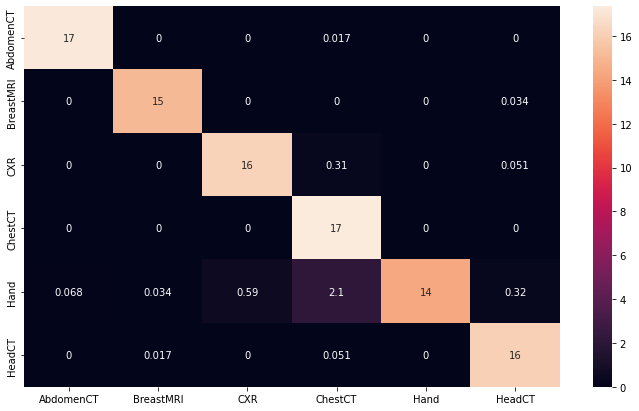

In [33]:
# constant for classes
classes = ['AbdomenCT', 'BreastMRI','CXR','ChestCT','Hand','HeadCT']

# Build confusion matrix
cf_matrix = confusion_matrix(true, pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *100, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
print("Confusion Matrix for CoAt Net")
sns.heatmap(df_cm, annot=True)

In [34]:
print(cf_matrix)

[[1016    0    0    1    0    0]
 [   0  888    0    0    0    2]
 [   0    0  957   18    0    3]
 [   0    0    0 1023    0    0]
 [   4    2   35  124  848   19]
 [   0    1    0    3    0  951]]


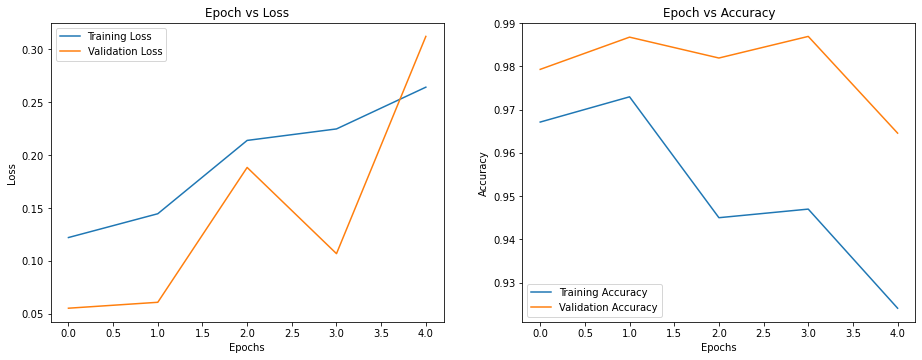

In [35]:
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)